# Generate More
#### This Generate more is like saying, "Make More of these that sounds like this"

- Under the hood, generate more is a character level language model
- Character level language model means, it will predict next character based on the previous characters

## Current language models are:
- Bigrams
- Bag of words
- MLP
- RNN
- GRU
- Transformers

# Part-1: Stastical Approach

### What is **Statistical Approach**

1. **Character-Level Bigram Representation**:
   The model captures dependencies between consecutive characters by constructing a bigram count matrix `N`, where each entry `N[i, j]` records how often character *j* follows character *i* in the training corpus.

2. **Probability Distribution Estimation**:
   By normalizing the bigram count matrix row-wise, we transform raw frequencies into conditional probability distributions `P(next_char | current_char)`. This represents a **maximum likelihood estimation** of the bigram probabilities.

3. **Generative Process**:
   Text generation is performed by sampling characters sequentially from the learned probability distributions using multinomial sampling, starting from a special start-of-sequence token and terminating at an end-of-sequence token.

4. **Purely Statistical Nature**:
   This approach does not involve trainable parameters or gradient-based optimization. It is purely **statistical modeling** based on co-occurrence counts from the dataset.

5. **Advantages & Limitations**:

   * Advantage: Simple, interpretable, and directly based on corpus statistics.
   * Limitation: Cannot generalize beyond observed bigrams; lacks the ability to capture higher-order dependencies or semantic structure.

6. **Baseline for Neural Models**:
   The statistical bigram model provides a foundational baseline. It highlights the limitations of count-based approaches, motivating the shift toward **neural network-based language models** that learn distributed representations and optimize via loss functions.

In [29]:
# load the dataset
words = open('names.txt', 'r').read().splitlines()

In [30]:
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [31]:
len(words)

32033

In [32]:
biagram_count = dict()
for w in words:
    chars = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2)
        biagram_count[bigram] = biagram_count.get(bigram, 0) + 1

In [33]:
import torch

In [34]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [35]:
chars = sorted(list(set(''.join(words))))

In [36]:
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

# stoi = StringToInteger
# itos = IntegerToString

In [37]:
for w in words:
    chars = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        N[idx1, idx2] += 1

## Visualizing the Bigram Count Tensor

* I’ve created a tensor that represents the frequency of word pairings. For example, if the bigram is `'ab'`, the tensor shows how many times `'b'` follows `'a'` in our corpus.

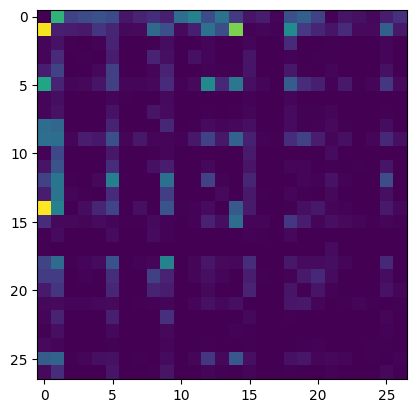

In [38]:
import matplotlib.pyplot as plt
plt.imshow(N)

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chars = itos[i] + itos[j]
        plt.text(j, i, chars, ha = 'center', va = 'bottom')
        plt.text(j, i, N[i, j].item(), ha = 'center', va = 'top')
plt.axis('off')

(-0.5, 26.5, 26.5, -0.5)

## Random garbage results of the model

In [ ]:
generator = torch.Generator().manual_seed(42)

for i in range(5):
    idx = 0
    while True:
        p = torch.ones(27)
        p = p / p.sum()
        idx = torch.multinomial(p, num_samples=1, generator=generator, replacement=True).item()
        print(''.join(itos[idx]), end = '')
        if idx == 0:
            break
    
    print()

yeosyohlvfbgqqdlxgktsmzmgwnyb.
tryvwdxchwndenbedlppmjiaeqybkejmszqsqgtoyzjovtkimpupooznnyzujfosjvslrumxtonaclpgcyaqxknvzioiuqrtensqvgsumjqwqeioionyyrmnyctrjzdwtyazxdbpnftaauzyskakoth.
eyumwlni.
zripawaejtxpoxkelygylxsqfdcnidebwfmbiaaewbtorpaclulyaixbxsmpsvqccgkmbr.
bcqfmfdvushlqqaspiaycg.


## Producing Initial Words from the Statistical Model

In [ ]:
P = N.float()
P /= P.sum(dim=1, keepdim=True)

# Setting up the generator
generator = torch.Generator().manual_seed(42)
for i in range(20):
    idx = 0
    while True:
        p = P[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()
        print(''.join(itos[idx]), end = '')
        if idx == 0:
            break
    print()

ynelinarahuminn.
mexa.
r.
blesonshlladiyn.
leeieloteeceniabanailianavar.
ayn.
adena.
id.
hangllie.
n.
meela.
ja.
joy.
kly.
jonlizas.
onassa.
era.
a.
ahyamusali.
iemronayoh.


## **Conclusion:**
* I trained a bigram language model based purely on statistical analysis of word occurrences and bigram counts.
* Although the model’s output doesn’t produce meaningful words, it still performs better than completely random results.


## Now, let’s evaluate our model’s performance by examining its loss.

**Goal:**
1. Maximize the likelihood of the data with respect to the model’s parameters (statistical modeling).
2. This is equivalent to maximizing the log-likelihood.
3. Which, in turn, is equivalent to minimizing the negative log-likelihood.
4. Finally, this reduces to minimizing the average negative log-likelihood.

### Conclusion: 
- These optimization formulations are mathematically equivalent representations of the same objective.
- Incorporating the loss function allows us to quantify the quality of our model’s predictions.

In [ ]:
log_likelihood = 0.0
n = 0
for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2) 
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        negative_log_likelihood = -log_likelihood
        n += 1
        # print(f"P({bigram}) = {prob:.4f} | logprob = {logprob:.4f}") # for better log

print(f"log likelihood = {log_likelihood}")
print(f"negavtive log likelihood (Loss Function) = {(negative_log_likelihood):.4f}")
avg_statical_loss = negative_log_likelihood/n
print(f"Average of negative log likelihood = {avg_statical_loss:.4f}")

log likelihood = -559891.75
negavtive log likelihood (Loss Function) = 559891.7500
Average of negative log likelihood = 2.4541
